# Bunch of examples of how you can automate selecting collective variables from dynamics trajectories

In [2]:
%matplotlib inline
import ddr
import numpy as np
import glob
from qml.qmlearn.data import Data
import sklearn
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from qml.ml.kernels.distance import manhattan_distance, l2_distance

Load a trajectory of a hydrogen abstraction involving hexane and cyanide.
H3 is taken off C4 by C0

/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


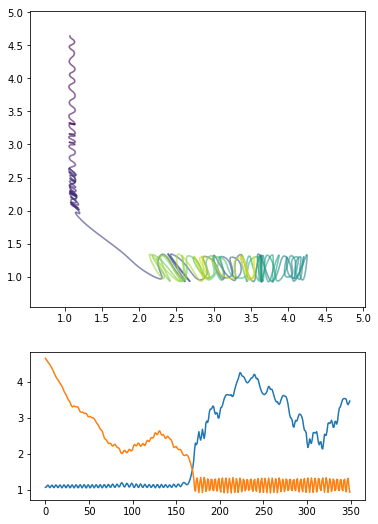

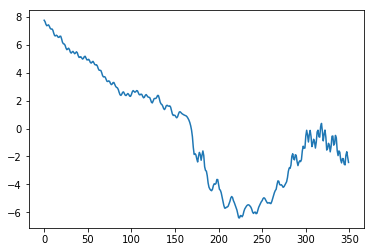

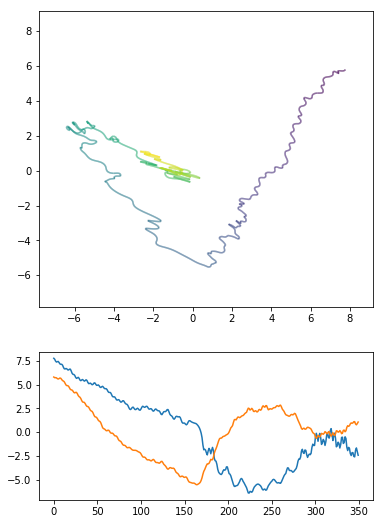

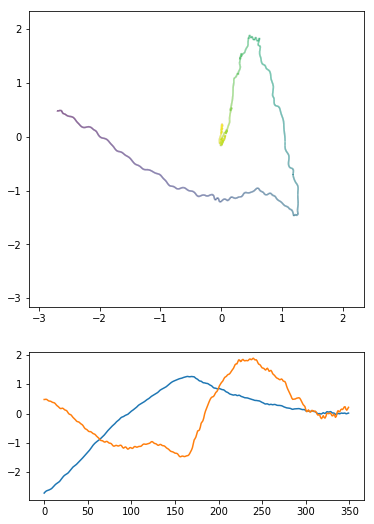

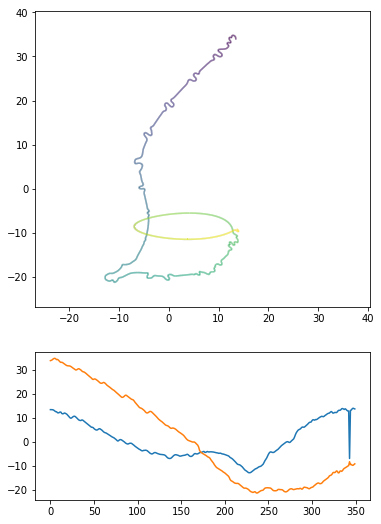

KeyboardInterrupt: 

In [1]:

filenames = sorted(glob.glob('data/hexane/hex_*.xyz'))
# Use a QML data object, that stores nuclear_charges as well as coordinates
# (data.nuclear_charges, data.coordinates)
# The reaction happens around frame 7570 or so, so only load a small
# window around the abstraction
data = Data(filenames[7400:7750])
# Create some test data that uses some snapshots at the beginning and end
# of the trajectory
test_data = Data(filenames[:100] + filenames[-100:])
# Since this is a simple reaction, the natural reaction coordinates are
# the interatomic distances between atoms 0-3 and 0-4.

# Calculate the euclidian distances between the abstracted hydrogen
# and the two relevant carbons.
d1 = np.sum((data.coordinates[:,3] - data.coordinates[:,4])**2, axis=1)**0.5
d2 = np.sum((data.coordinates[:,3] - data.coordinates[:,0])**2, axis=1)**0.5
# Visualize the data. Top plot shows one reaction coordinate versus another,
# with the colour indicated evolution over time.
# The bottom plots shows how each reaction coordnate evolves over time.
# The plot can be saved to img.png by using ddr.colorplot(d1,d2, 'img') instead.
ddr.colorplot(d1,d2)

# If we don't know exactly which coordinates make the best reaction coordinates
# We can create some sort of high dimensional representations for the system,
# and then apply some dimensionality reduction algorithm.
# For example the upper triangle of the interatomic distance matrix, followed
# by PCA.

# Get the interatomic distances for all molecules
rep = ddr.Distances().fit_transform(data)
# Do PCA with 1 component
reduced_space = PCA(n_components=1).fit_transform(rep)
# Visualize
ddr.colorplot(reduced_space)
# Do PCA with 2 components
reduced_space = PCA(n_components=2).fit_transform(rep)
# Visualize
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# Instead of first generating a representation and then reducing dimensions
# We can construct a pipeline model that does all of it in one go:
model = make_pipeline(ddr.Distances(), PCA(n_components=2))
# We can fit on one set of data
model.fit(data)
# And transform the same or another set (or use fit_transform to both fit and transform)
reduced_space = model.transform(test_data)

# We can do the dimensionality reduction with many other algorithms. Any of the methods
# from http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition
# or from http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold
# should work fine.
# tICA is an interesting choice since it treats the data as a time-series:
model = make_pipeline(ddr.Distances(), ddr.tICA(n_components=2))
reduced_space = model.fit_transform(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# Some dimensionality reduction techniques such as TSNE works differently than PCA
# in the sense that you can't transform data that wasn't used to create the manifold.
# One way around this is to fit a regression model to the manifold and use that to do
# the transform
# First get the reduced space
org_reduced_space = make_pipeline(ddr.Distances(), TSNE(n_components=2)).fit_transform(data)
ddr.colorplot(org_reduced_space[:,0], org_reduced_space[:,1])
# Create the Kernel Ridge Regression pipeline.
basemodel = make_pipeline(ddr.Distances(), KernelRidge())
# The optimal parameters can be cross validated by doing a grid search
params = {'kernelridge__alpha': 10.**np.arange(-9,-4, 0.5),
          'kernelridge__kernel': ['linear', 'rbf', 'laplacian', 'polynomial'],
          'kernelridge__gamma': 10.**np.arange(-9,-4, 0.5),
          }
model = GridSearchCV(basemodel, param_grid=params,
        cv=sklearn.model_selection.KFold(n_splits=3, shuffle=True),
            scoring='neg_mean_squared_error')

model.fit(data, org_reduced_space)
# Print the best parameters found by cross validation
print(model.best_params_)
# The now trained model can be used to run predictions on the same data
reduced_space = model.predict(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])
# Or some other data (which you weren't able to do before the regression)
reduced_space = model.predict(test_data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# It can be hard to figure out which atoms are involved in the reaction coordinates
# found by dimensionality reduction. One way of doing this is to take a structure
# Do a bunch of small displacements to its coordinates and see how the reduced space
# changes. The ddr.significance function takes one or more indices of snapshots in the
# data object, creates minor displacements and calculates the partial derivatives of the
# reduced space with respect to atomic coordinates. It then calculates the norm for each atom
# and calculates the percentage of the total norm that each atom contributes with.

model = make_pipeline(ddr.Distances(), PCA(n_components=2))
reduced_space = model.fit_transform(data)

# Try to get the significance for two different structures
s = ddr.significance(data, [0,170], model)
print((s[0,0]))
print((s[0,1]))
print((s[1,0]))
print((s[1,1]))

# We can get e.g. all atoms that contribute more than 10% to a reaction coordinate by
s_sorted = np.sort(s[0,0])[::-1]
s_args = np.argsort(s[0,0])[::-1]
significant_indices = s_args[s_sorted > 0.1]
print(significant_indices)

# Note that all three structures have the same significances, since distances are linear.
# If we use inverse distances instead this trend changes, so the significance is structure
# dependant.

model = make_pipeline(ddr.InverseDistances(), PCA(n_components=2))
reduced_space = model.fit_transform(data)
rep = model.transform(data)
#ddr.colorplot(reduced_space[:,0], reduced_space[:,1])
s = ddr.significance(data, [0,170], model)
print((s[0,0]))
print((s[0,1]))
print((s[1,0]))
print((s[1,1]))

# As an alternative to simple distances, we can use representations from machine learning.
# We can use global representations that describe the entire molecular system. This makes
# sure that we have permutation invariance such that our hexane reaction coordinates will
# be able to describe abstraction of any H atoms.

model = make_pipeline(ddr.GlobalSLATM(), ddr.tICA(n_components=2))
reduced_space = model.fit_transform(data)
rep = model.transform(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# We could also use an atomic representation concatenated together, but this makes us lose permutation invariance
# Change parameters since we would run into memory issues otherwise
dgrid = 0.3
sigma = 0.05/0.03 * dgrid
model = make_pipeline(ddr.AtomicSLATM(dgrid2=dgrid, dgrid3=dgrid, sigma2=sigma, sigma3=sigma), ddr.tICA(n_components=2))
reduced_space = model.fit_transform(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# Or just use the atomic representation of the cyanide carbon, which would make the representation
# permutation invariant again
model = make_pipeline(ddr.AtomicSLATM(indices=[0]), ddr.tICA(n_components=2))
reduced_space = model.fit_transform(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# An alternative approach is to use a subset of the molecules as basis and then
# calculate the distance (using some metric) between them and all other molecules.

# One way of doing this would be to align every molecule to the basis molecules,
# and calculate the rmsd displacement:

# Use the molecules near the transition as basis
indices = np.arange(150, 190)
model = make_pipeline(ddr.Align(indices), ddr.tICA(n_components=2))
reduced_space = model.fit_transform(data)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# Alternatively we can use the same machine learning representations as before
# and calculate the manhattan distance to the basis representations
indices = np.arange(150,190)
reps = ddr.GlobalSLATM().fit_transform(data)
basis_reps = reps[indices]
distance_features = manhattan_distance(reps, basis_reps)
print(distance_features.shape)
reduced_space = ddr.tICA(n_components=2).fit_transform(distance_features)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])

# And we could transform the distances with Kernels
# (which is KernelPCA in sklearn, but doesn't exist for tICA)
indices = np.arange(150,190)
reps = ddr.GlobalSLATM().fit_transform(data)
basis_reps = reps[indices]
distance_features = manhattan_distance(reps, basis_reps)
kernel = np.exp(-distance_features/2.0)
reduced_space = ddr.tICA(n_components=2).fit_transform(kernel)
ddr.colorplot(reduced_space[:,0], reduced_space[:,1])